# Imports

In [13]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import VotingClassifier
vectorizer = TfidfVectorizer(stop_words='english')

# For plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm
import warnings

# For HTML display styling
from IPython.display import display, HTML


# Configure plotting style
%matplotlib inline
sns.set_style('darkgrid')

warnings.filterwarnings("ignore", category=UserWarning, message=".*FitFailedWarning.*")


# Utility Functions

In [14]:
# To Separate Various Contents
def display_with_border(content):
    display(HTML(f"""
    <div style='border: 2px solid blue; padding: 10px;'>
        {content}
    </div>
    """))

# Loading the data
def load_data(file_path):
    try:
        return pd.read_csv(file_path, encoding='latin-1')
    except pd.errors.ParserError as e:
        display_with_border(f"Error reading the CSV file: {e}")
        return None



# Loading Data

In [15]:
file_path = 'cleaned_tweets.csv'
df = load_data(file_path)

if df is None:
    raise SystemExit("Failed to load data. Exiting...")

display_with_border(df.head(10).to_html())

,label,tweet,cleaned_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset cant update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving im mad cant see
5,0,@Kwesidei not the whole crew,whole crew
6,0,Need a hug,need hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?",hey long time see yes rain bit bit lol im fine thanks hows
8,0,@Tatiana_K nope they didn't have it,nope didnt
9,0,@twittera que me muera ?,que muera


# Data Cleaning

In [16]:
if 'cleaned_tweet' not in df.columns or 'label' not in df.columns:
    raise KeyError("Missing required columns: 'cleaned_tweet' or 'label'")

df = df.drop_duplicates(subset=['cleaned_tweet']).reset_index(drop=True) # reset index again after dropping rows
df = df.dropna(subset=['cleaned_tweet']).reset_index(drop=True)

df['label'] = df['label'].replace({4: 1})
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
if len(df_class_0) == 0 or len(df_class_1) == 0:
    raise ValueError("The dataset must contain samples from both classes (0 and 1).")
display_with_border(df['label'].value_counts().to_frame().to_html()) #to_frame converts to pandas dataframe

X = df['cleaned_tweet']
y = df['label']
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X_vectorized = vectorizer.fit_transform(X)

display_with_border("TF-IDF vectorization complete.")


,count
label,
0,747555
1,731312


# Split into training and testing set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42, stratify=y) # stratify=y used to maintain same proportion of class labels as in original dataset
display_with_border(f"Training set size: {X_train.shape[0]}<br>Testing set size: {X_test.shape[0]}")


# Training Logistic Regression

In [18]:
model = LogisticRegression(max_iter=30000, random_state=42, C=1.0)
for _ in tqdm(range(1), desc="Training model"):
    model.fit(X_train, y_train)

display_with_border("Model training complete.")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
display_with_border(f"Model Accuracy on Test Set: {accuracy: .4f}")

report = classification_report(y_test, y_pred, target_names=['Sad', 'Happy'])
display_with_border(f"<pre>{report}</pre>")

Training model: 100%|██████████| 1/1 [03:36<00:00, 216.39s/it]


# Model testing with custom input

In [ ]:
def preprocess_text(text):
    # Text preprocessing steps
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    return text

def predict_sentiment(text):
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    # Vectorize the text
    text_vectorized = vectorizer.transform([cleaned_text])
    # Predict the label
    prediction = model.predict(text_vectorized)[0]
    # Map the label to sentiment
    sentiment = 'Happy' if prediction == 1 else 'Sad'
    return sentiment

# Input a line of text and get the sentiment label
input_text = input("ENTER THE LINE")
sentiment = predict_sentiment(input_text)
display_with_border(f"The predicted sentiment is: {sentiment}")

# Graphs

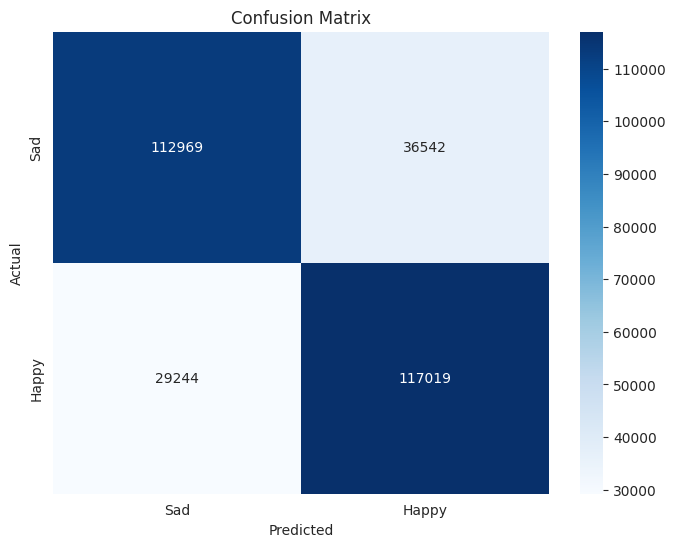

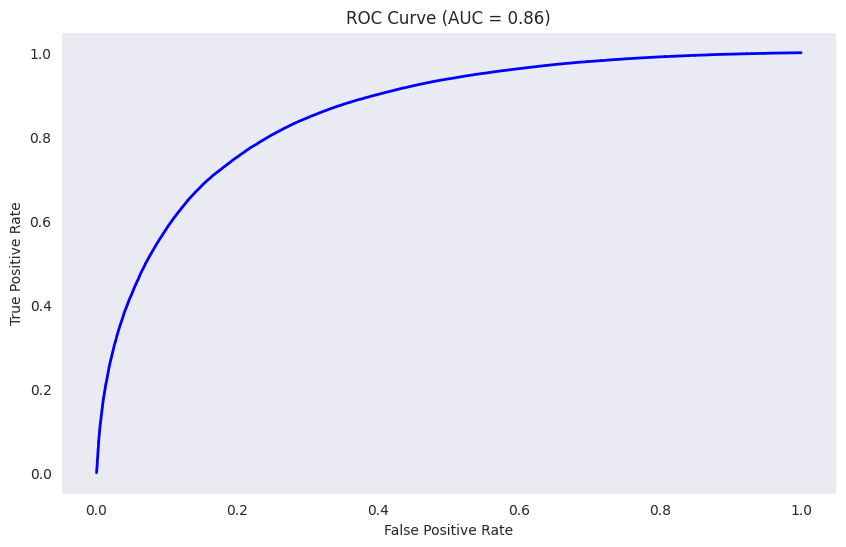

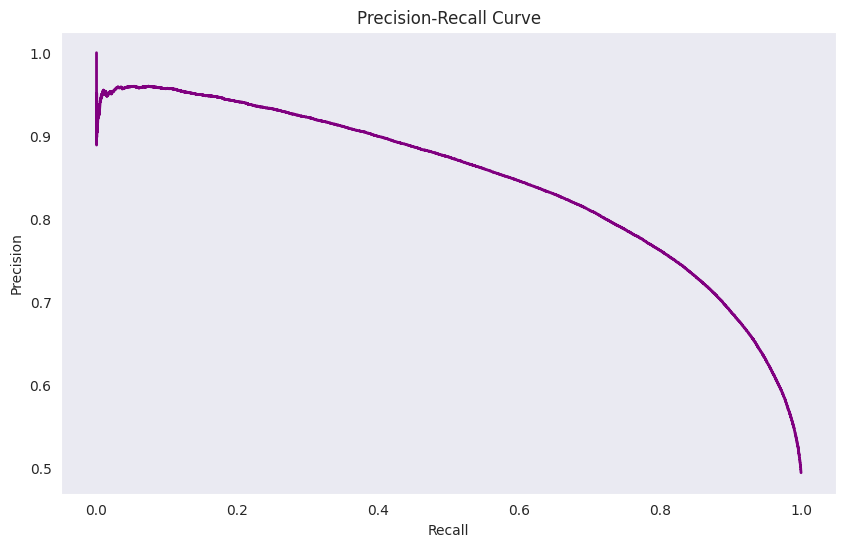

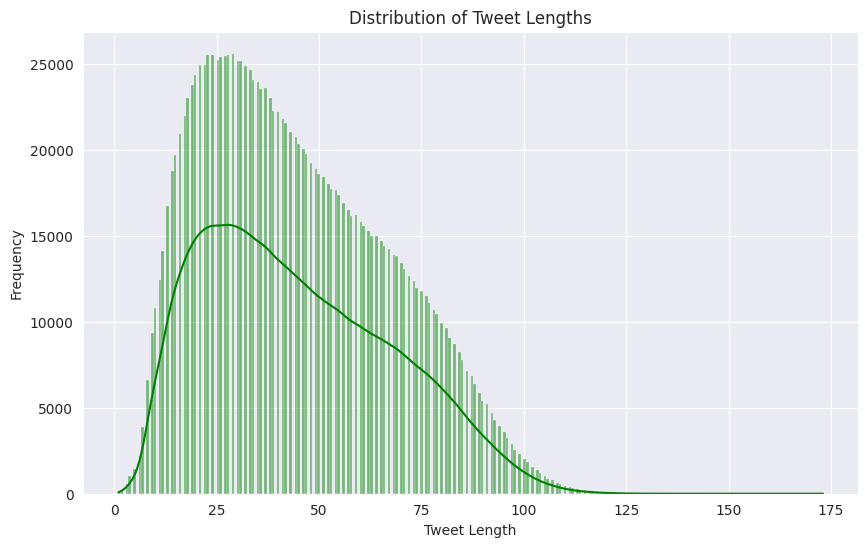

<ipython-input-19-e75f8aeb3a8c>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, palette='viridis')


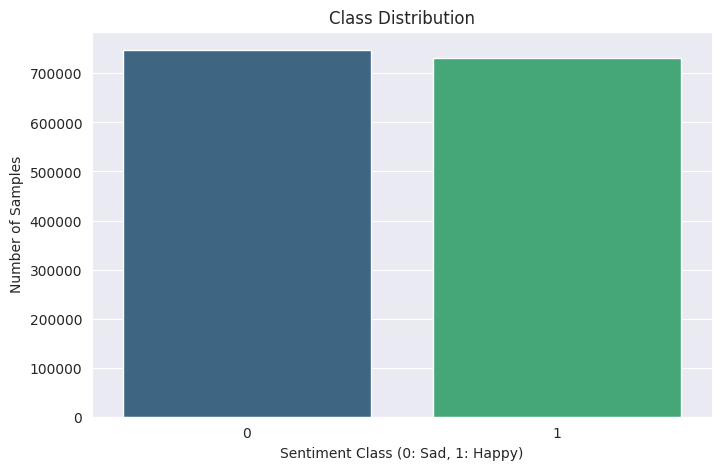

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Sad', 'Happy'],
    yticklabels=['Sad', 'Happy'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
display_with_border("Confusion Matrix displayed.")

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.grid()
plt.show()
display_with_border("ROC Curve displayed.")


precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()
display_with_border("Precision-Recall Curve displayed.")

tweet_lengths = df['cleaned_tweet'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, kde=True, color='green')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()
display_with_border("Distribution of Tweet Lengths displayed.")

plt.figure(figsize=(8, 5))
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, palette='viridis')
plt.xlabel('Sentiment Class (0: Sad, 1: Happy)')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()
display_with_border("Class Distribution displayed.")


# Word Cloud

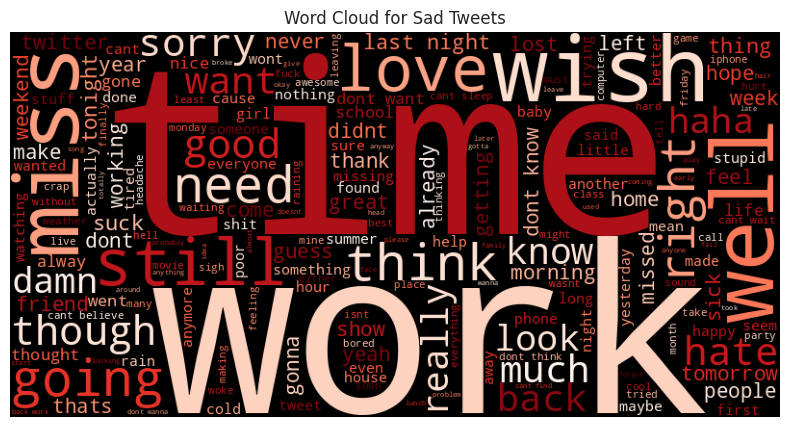

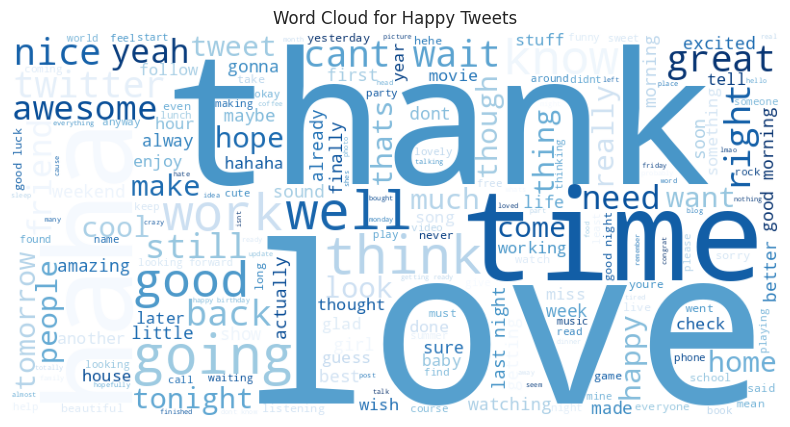

In [20]:
sad_words = ' '.join(
    [word for word in ' '.join(df[df['label'] == 0]['cleaned_tweet']).split() if len(word) >3 and word!="today"]
)

happy_words = ' '.join(
    [word for word in ' '.join(df[df['label'] == 1]['cleaned_tweet']).split() if len(word) > 3 and word!="today"]
)


# Generate word cloud for Sad tweets
sad_wordcloud = WordCloud(
    width=800, height=400, max_words=200, background_color='black', colormap='Reds'
).generate(sad_words)
plt.figure(figsize=(10, 5))
plt.imshow(sad_wordcloud)
plt.axis('off')
plt.title('Word Cloud for Sad Tweets')
plt.show()
display_with_border("Word Cloud for Sad Tweets displayed.")

# Generate word cloud for Happy tweets
happy_wordcloud = WordCloud(
    width=800, height=400, max_words=200, background_color='white', colormap='Blues'
).generate(happy_words)
plt.figure(figsize=(10, 5))
plt.imshow(happy_wordcloud)
plt.axis('off')
plt.title('Word Cloud for Happy Tweets')
plt.show()
display_with_border("Word Cloud for Happy Tweets displayed.")

# Naive Bayes and Voting Classifier

In [21]:
modelNB = MultinomialNB(alpha=1)
modelNB.fit(X_train, y_train)

# Predict and evaluate

y_pred = modelNB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
display_with_border(f"Model Accuracy on Test Set: {accuracy: .4f}")

report = classification_report(y_test, y_pred, target_names=['Sad', 'Happy'])
display_with_border(f"<pre>{report}</pre>")

In [22]:
# Voting Classifier (combining multiple models)
estimators = [
    ('modelNB', modelNB),
    ('modelLR', model),
    # Add other models as needed
]
voting_model = VotingClassifier(estimators=estimators, voting='soft')  # 'hard' or 'soft'
voting_model.fit(X_train, y_train) # Use the same X_train and y_train as bagging_model_tfidf

y_pred = voting_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
display_with_border(f"Model Accuracy on Test Set: {accuracy: .4f}")

report = classification_report(y_test, y_pred, target_names=['Sad', 'Happy'])
display_with_border(f"<pre>{report}</pre>")

# Save the model in a pickel file

In [10]:
with open('Lates.pkl', 'wb') as model_file:
    pickle.dump((voting_model,vectorizer), model_file)
display_with_border("Model saved successfully as 'Latest.pkl'.")